## ECE495 In-class Exercise 4: Navigation Dynamics using Nengo

This ICE uses Nengo to sort an array using the bubble sort algorithm. The objectives of this ICE are to:

- Connect two integrators (building off of the integrator from `neuron_dynamics.ipynb`) to use acceleration as your input.
- Implement the same thing using a multi-dimensional neuron.
- Extend your position, velocity, and acceleration components to two dimensions (i.e. x- and y- directions).

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

from nengo.dists import Uniform
from nengo.utils.matplotlib import rasterplot
from nengo.processes import Piecewise

### Nengo Dynamics Review

Recall from `neuron_dynamics.ipynb` that we used recurrent neurons to perform a variety of functions. As a refresh, we started each time with this linear dynamical system:

$$\dot{x}=f(x)+g(u)=Ax+Bu$$

where $x$ is our output state, $u$ is our input. $A$ and $B$ determine the direction/strength of $x$ and $u$ contributions. 

However, Nengo neurons have their own inherent feed forward dynamics: $\dot{x(t)}=-\frac{1}{\tau}(x(t))-u(t))$. These dynamics tell us that $x_{new} = x_{old}+\dot{x}$, where $x_{new}$ is the output of our neuron ensemble and $\dot{x}$ is the input to our ensemble (draw block diagram).

To get the neuron ensemble to behave in the way a typical linear dynamical system behaves - i.e. $\dot{x}=f(x)+g(u)=Ax+Bu$ - we must define different functions $f'$ and $g'$. If this doesn't make sense, please go back and review the beginning of our notebook and/or watch [this video](https://youtu.be/Fl4cfZCie-w?si=2o1grgrPgoPkuPvV) from 5 to 28 minutes. 

The takeaway: Using $f'$ as the feedback function and $g'$ as the feed forward function, _we convert the inherent neuron dynamics into typical controls system dynamics._

### Two Integrators in Sequence

In `neuron_dynamics.ipynb`, we converted a 1-D velocity signal $v$ into position $p$ using an integrator. Given that $\dot{p}(t)=v(t)$ (i.e. derivative of position is velocity), it should make sense that with each time step, we move toward a position (our output in meters) at some velocity (our input in m/s). 

To convert the inherent neuron dynamics to typicaly control dynamics, we defined functions for our feed forward and feedback aspects of our recurrent network for an integrator to be:

$$f'(x)= \tau f(x) + x = \tau Ax + x = x$$
$$g'(u)=\tau g(u)  =\tau Bu = \tau Iu =\tau u$$ 

Intuitively, this should make sense. Each time step, our new position $p$ is equal to dynamics $p = f' + g' = x + \tau u$ where $x$ is our output state $x$ and $u$ is our input velocity. If our velocity is 1m/s and we run our simulation for 1 second, we should move 1 meter total. However, we have many time steps within that 1 second, so we move a fraction of 1m each time step - you can think of $\tau$ as the scale term, i.e. how quickly we respond to the input velocity.

For this example, we will connect the integrator we created in `neuron_dynamics.ipynb` to an identical integrator. The final output of the network is position $p$ (i.e. the output of the second neuron ensemble), and the input to that ensemble is velocity (i.e. $\dot{p}$). We connect an neuron ensemble to the front end, from which the output is velocity (give that's the input to the second ensemble). That means the input to the first ensemble (and therefore entire network) is.... acceleration ($\dot{v}$)!

Our input acceleration is a piecewise function so you can see that the output is integrating (i.e. summing over time) the input. If we have a constant acceleration, we should see velocity ramp up. Recall, for a constant velocity, we have position ramp up. This time, with a velocity changing over time, we should see position change faster for higher velocities - so we should _not_ see a straight line output from the network. Let's give it a go:

In [3]:
model = nengo.Network(label="Sequence Integrators")
with model:
    # create the recurrent neuron ensemble
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)

    # create piecewise input
    input = nengo.Node(Piecewise({0: .5, 1: 0, 2: -1, 3: 0, 4: 1, 5: 0}))

    # Using a long time constant for stability (less noise)
    tau = 0.1 
    
    # if you wanted to define functions, they might look like this
    #def forward(u):
    #    return tau*u
    #def recurrent(x):
    #    return x

    # Connect the input to the network (Ensemble A)
    # The same time constant as recurrent to make it more 'ideal'
    nengo.Connection(input, A, transform=[[tau]], synapse=tau)
    # Connect the population to itself
    nengo.Connection(A, A, transform=[[1]], synapse=tau)  
    
  
    # Connect the output of Ensemble A to Ensemble B
    # The same time constant as recurrent to make it more 'ideal'
    nengo.Connection(A, B, transform=[[tau]], synapse=tau) 
    # Connect the population to itself
    nengo.Connection(B, B, transform=[[1]], synapse=tau) 

#### Probe it and Run it

In [4]:
with model:
    # Add probes
    input_probe = nengo.Probe(input)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 6 seconds
    sim.run(6)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### Plot it

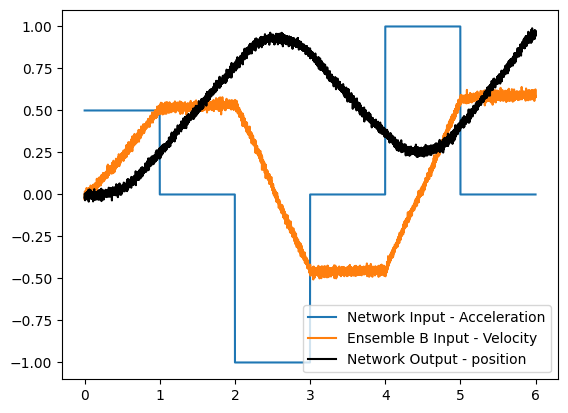

In [5]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], label="Network Input - Acceleration")
plt.plot(sim.trange(), sim.data[A_probe], label="Ensemble B Input - Velocity")
plt.plot(sim.trange(), sim.data[B_probe], "k", label="Network Output - position")
plt.legend()

Cool!

### Convert Integrators in Sequence into a Single Neuron Ensemble (and do the same thing)

We can make this more efficient by creating a 2D neuron that outputs both velocity $v$ and position $p$ as a function of input acceleration $a$, similarly constructed to the oscillator example from `neuron_dynamics.ipynb`. In this case, our input $u$ is acceleration, i.e. $a=\dot{v}$ and our output is both position $p$ and velocity $v$, i.e. $x = \begin{bmatrix} p \\ v \end{bmatrix}$.  
  
  
Now we just need our matrices $A$ and $B$ for linear dynamics $\dot{x}=f(x)+g(u)=Ax+Bu$ in order to compute $f'$ and $g'$.  
  
  
Let's think through this: $u$ is acceleration $a=\dot{v}$. We don't want to mess with that - we just want our input acceleration to be our chosen acceleration (the blue piecewise function above). That's 1D and our neuron ensemble is 2D, which means we need a matrix that converts our 1D acceleration to a 2D input.  Therefore, matrix $B=\begin{bmatrix} 0 \\ 1 \end{bmatrix}$. Why?? Because our output $x$ is equal to $\begin{bmatrix} p \\ v \end{bmatrix}$ and in our integrator, our input $u=\begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix}$. We do not have an input velocity, only an input acceleration. Given $a=\dot{v}$, we get $B=\begin{bmatrix} 0 \\ 1 \end{bmatrix}$.  
  
Before we dive into determining A, do you remember our working memory example? If you had any contribution from A, you gradually reset your output to zero. This means we need an $\alpha$ term that's only active when we provide acceleration and zero when we don't (so it holds velocity instead of resetting it).
  
Now, we know $\dot{x}=Ax+Bu$. Let's find A by relating $\dot{x}$ to $x$. Given we know $\dot{x}=\begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix}$ and $x=\begin{bmatrix} p \\ v \end{bmatrix}$:


$$\dot{x} = \begin{bmatrix}
    \dot{p} \\
    \dot{v} 
\end{bmatrix} = \begin{bmatrix}
		            0 & 1 \\
		            0 & 0  
	            \end{bmatrix} \begin{bmatrix}
                                    p \\
                                    v 
                                \end{bmatrix} = Ax$$

From there, define your $f'$ and $g'$ to create the 2D neuron ensemble to implement these dynamics (insert your matrices in place of the `???`). You should get a very similar plot to the integrators in sequence.



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

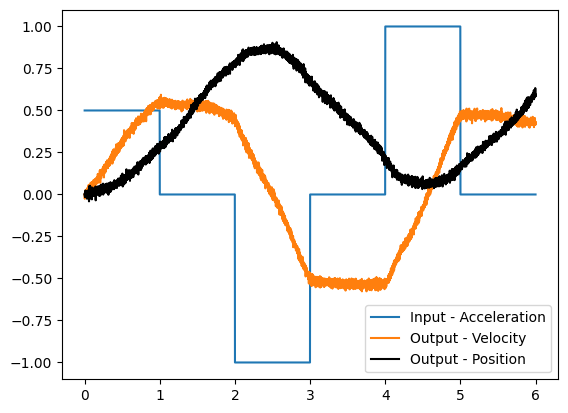

In [6]:
model = nengo.Network(label="2D Nav Dynamics")
with model:
    # Create the recurrent neuron ensemble
    C = nengo.Ensemble(200, dimensions=2)

    # Create piecewise acceleration controli nput
    input_accel = nengo.Node(Piecewise({0:  .5, 1: 0, 2: -1, 3: 0, 4: 1, 5: 0}))

    # Using a long time constant for stability (less noise)
    tau = 0.1
    #A is [01/00]
    feedback_matrix = [[1,tau], [0,1]]
    nengo.Connection(C, C, transform=feedback_matrix, synapse=tau)  
    
    feedfwd_matrix = [[0] ,[tau]]
    nengo.Connection(input_accel, C, transform=feedfwd_matrix, synapse=tau)  

    # Probe and run
    # Add probes
    input_probe = nengo.Probe(input_accel)
    position_probe = nengo.Probe(C[0], synapse=0.01)
    velocity_probe = nengo.Probe(C[1], synapse=0.01)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 10 seconds
    sim.run(6)

# Plot the decoded output (poisiton) of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], label="Input - Acceleration")
plt.plot(sim.trange(), sim.data[velocity_probe], label="Output - Velocity")
plt.plot(sim.trange(), sim.data[position_probe], "k", label="Output - Position")
plt.legend()

### Make everything 2D!

The two above integrators only account for movement in one dimension/direction (i.e. we are only moving east/west). We'd like to add a second dimension/direction to our input signal (i.e. north/south) and use acceleration to control the movement of our "vehicle".

Using the same methodology above for your 2D integrator, find your $A$ and $B$ matrices and use those to find your Nengo $f'$ and $g'$ functions to achieve the dynamics.

Then using acceleration as your input (now with $a_x$ for east/west and $a_y$ for north/south), start off by heading north, then make your "vehicle" turn right (east), then right (south), then left (east). 

Hints:

- You will need to use a [Nengo process called `PresentInput`](https://www.nengo.ai/nengo/examples/advanced/processes.html), which is similar to Piecewise, except now you can make your input 2 dimensions, one for $a_x$ and one for $a_y$
- Your output state vector should be $x=\begin{bmatrix} p_x \\ p_y \\ v_x \\ v_y \end{bmatrix}$ and your input should be $u=\begin{bmatrix} a_x \\ a_y \end{bmatrix}$
- The size of your $f'$ matrix should be $4\times4$ and the size of your $g'$ matrix should be $4\times2$.
- Negative velocity moves you in a negative direction. If you start with positive acceleration, changing it to negative gradually gets you to a negative velocity (because it does not instantaneously change from positive to negative - you should have seen that in your last two plots). _Your direction will not change until your velocity is negative!_
- Your neurons will drift (you can try this out by putting in zero acceleration and seeing what happens to velocity and position... it's bad!). This is real-world stuff! Kalman filters help us know where we are in between GPS signals and require feedback just like our neurons. Not only are you feeding back signal, but you are also feeding back noise and/or error (also much like our neurons - think through our noisy plots!). Said noise/error only grows over time as it continues to be fed back in and accumulate. This is the definition of drift - you are drifting away from your actual position - in this case, 0.  Even if you aren't wanting to move in a particular direction (yet), it might be wise to try to stabilize your dynamics using a small input in a particular direction you know you might be using soon. Such as... I know I want my vehicle to head north in a few seconds, so I'll start it off with a super small positive number (instead of zero) to make sure it's heading in the right direction when it's time. Note: this will bias your signal when you try to send your velocity back to zero (next hint). 
- To make a 90 degree turn, if you already have movement in the y direction (north), you'll need to pump the breaks hard to quickly turn right (east) -- just like driving! That way you aren't continuously moving north with velocity greater than 0 (per the last hint) while trying to actually move east . You need your velocity to get back to zero in the north direction to change your direction to east.
- I used 8 time steps (and therefore ran my simulation for 8s) to complete my turns (2 time steps  for each turn, 1 second each, total 4*2=8)


**Your plots will not look the same twice, ever! But it should be clear that you're making the correct turns with your "vehicle" the majority of the time.** This is due to noise and initial neuron parameters. Think through what your velocity plots should look like (in terms of shape). If that looks close, it works for me. **_Be sure to SAVE YOUR BEST PLOTS FOR THIS SECTION AND INCLUDE THEM ON GITHUB FOR YOUR SUBMISSION!_**

In [10]:
model = nengo.Network(label="Multidirectional Nav Dynamics")
with model:
    # Create the recurrent neuron ensemble
    D = nengo.Ensemble(700, dimensions=4)

    # Create piecewise acceleration control input
    # Note, I am initializing BOTH directions as the exact same dynamics from the past two parts
    # That way, you can confirm everything is connected properly first
    inputs = [[0, 1], [0, 0], [1, 0], [-.65, -2],[1.5, 1.5],[0,0]]
    #          [north],  [brakes], [east] , [brakes], [south], [brakes], [west], [brakes]
    input_accelX = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))
    input_accelY = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))

    process = nengo.processes.PresentInput(inputs, presentation_time=1)
    accel_input = nengo.Node(process)
    
   
    # Using a long time constant for stability (less noise)
    tau = 0.8

    feedback_matrix =[[1,0,tau,0], [0,1,0,tau], [0,0,1,0], [0,0,0,1]]
    #print(feedback_matrix)
    nengo.Connection(D, D, transform=feedback_matrix, synapse=tau)  
    
    feedfwd_matrix = [[0,0], [0,0], [tau,0], [0,tau]]
    #print(feedfwd_matrix)

    nengo.Connection(accel_input, D, transform=feedfwd_matrix, synapse=tau)  



#### Probe it, run it, plot it!

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

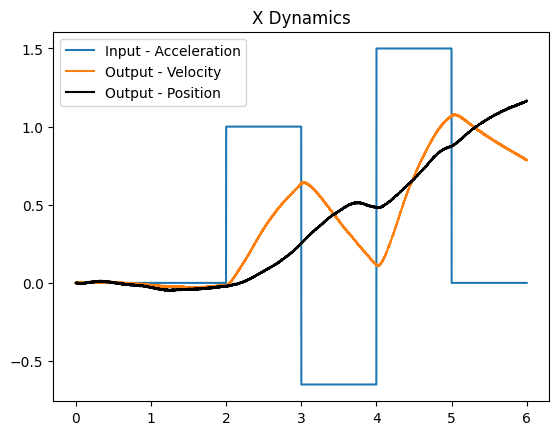

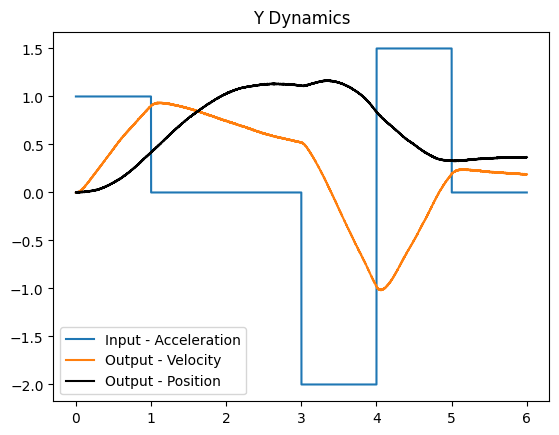

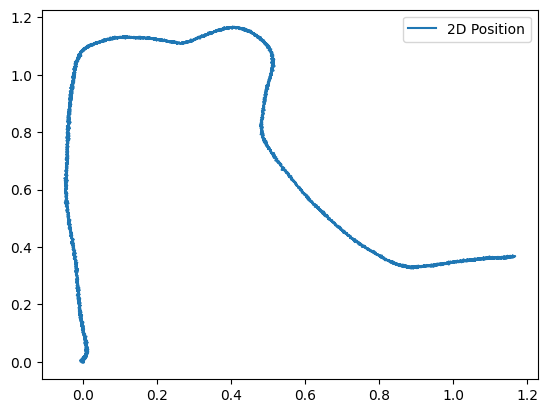

In [11]:
with model:
    # Probe and run
    # Add probes
    input_probe = nengo.Probe(accel_input)
    output_probe = nengo.Probe(D, synapse=0.06)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 10 seconds
    sim.run(6)

plt.figure()
plt.plot(sim.trange(), sim.data[input_probe][:,0], label="Input - Acceleration")
plt.plot(sim.trange(), sim.data[output_probe][:,2], label="Output - Velocity")
plt.plot(sim.trange(), sim.data[output_probe][:,0], "k", label="Output - Position")
plt.legend()
plt.title("X Dynamics")

# Plot the decoded outputs
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe][:,1], label="Input - Acceleration")
plt.plot(sim.trange(), sim.data[output_probe][:,3], label="Output - Velocity")
plt.plot(sim.trange(), sim.data[output_probe][:,1], "k", label="Output - Position")
plt.legend()
plt.title("Y Dynamics")

# Plot the birds-eye view of position
plt.figure()
plt.plot(sim.data[output_probe][:,0], sim.data[output_probe][:,1], label="2D Position")
plt.legend()